In [64]:
############################################################################
# FWC analysis
############################################################################
# -------------------------------------------------------------------------
# 1. Import FWC monthly data (topaz & smos_topaz (two depths to plots))
# 2. Calculate FWC in km3
# 3. Extract data from Beaufort Area
# 4. Calculate monthly/yearly mean values for BG area
# 5. Yearly lineplot of FWC Topaz (Grafica Eva - for comparing results)
# 6. Monthly lineplot comparing FWC Topaz vs FWC Smos-Topaz
# 7. Monthly lineplot comparing FWC Topaz vs FWC Smos-Topaz (SMOS_mask)
# -------------------------------------------------------------------------
# Author    : Maria Sanchez Urrea
# Email     : maria.sanchez.urrea@gmail.com
# Creation  : January 2023
############################################################################

nf = 108 # Final N
show_plots = True

# Choose the two versions you want to compare: '1m' '5m' '10m' '15m'
v1 = '16m'
v2 = '25m'
v3 = '29m'

import xarray as xr
import numpy as np
import pandas as pd
import sys
import regionmask

from datetime import datetime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cmocean import cm

#---------------------------------------------------------------------------
# Figure size (inches)
fh = 13
fw = 5

# Select attributes for plotting:

color1 = '#002AFF'
color2 = '#008000'
color3 = '#DE7D00'
color4 = '#0068FF'

# >> Lines color for timeplot --------------------

y1_color       = '#FF2A00'
y2_color       = '#002AFF'
y2_color_fwc   = '#0068FF'
area_facecolor = '#637DEA'
area_edgecolor = '#637DEA'
lw = 0.8

# >> Figure saved format (png, tiff, pdf) ---------
fs_format = 'png'

plt.rcParams["font.family"] = "serif"
mono_font = {'fontname':'monospace'} # for titles
fs        = 24 # fontsize


In [70]:
############################################################################
# 1. Data
############################################################################

path_save_fig = '/maps/'

# Pixel Area (km2) --------------------------------------------------------

path_area = '/Users/MUmbert/Library/Mobile Documents/com~apple~CloudDocs/Analysis/Curie/fwc/outputs_smos_topaz/'
df_area = pd.read_csv(path_area+'area.csv',encoding = "ISO-8859-1",delimiter=';',decimal='.', header=None)
area = df_area.to_numpy()
area = area[0:95,:] # 95 is arctic circle (66.5 aprox.)

#----------------------------------------------------------------------------
# FWC (m) TOPAZ4B data

path = '/Users/MUmbert/Library/Mobile Documents/com~apple~CloudDocs/Analysis/Curie/fwc/outputs_smos_topaz/'
filename_ssst = path+'topaz4b_monthly_fullArctic_fwc2011_2019_latlon_vSmean.nc'

dset_fwc_topaz_m = xr.open_dataset(filename_ssst)
fwc_topaz_m = dset_fwc_topaz_m.fwc[0:nf,0:95,:] # layer 0
#print(fwc_topaz_m)

lat = dset_fwc_topaz_m.latitude[0:95]
lon = dset_fwc_topaz_m.longitude
time = dset_fwc_topaz_m.time[0:nf]

#----------------------------------------------------------------------------
# FWC (m) SMOS-TOPAZ4B data - v1

filename_ssst2 = path+'smos_topaz4b_monthly_fullArctic_fwc2011_2019_'+v1+'_vSmean.nc'

dset_fwc_smos_topaz_m = xr.open_dataset(filename_ssst2)
fwc_smos_topaz_m = dset_fwc_smos_topaz_m.fwc[0:nf,0:95,:] # layer 0
#print(fwc_smos_topaz_m)

#----------------------------------------------------------------------------
# FWC (m) SMOS-TOPAZ4B data - v2

filename_ssst3 = path+'smos_topaz4b_monthly_fullArctic_fwc2011_2019_'+v2+'_vSmean.nc'

dset_fwc_smos_topaz5_m = xr.open_dataset(filename_ssst3)
fwc_smos_topaz5_m = dset_fwc_smos_topaz5_m.fwc[0:nf,0:95,:] # layer 0
#print(fwc_smos_topaz5_m)

#----------------------------------------------------------------------------
# FWC (m) SMOS-TOPAZ4B data - v3

filename_ssst4 = path+'smos_topaz4b_monthly_fullArctic_fwc2011_2019_'+v3+'_vSmean.nc'

dset_fwc_smos_topazv3_m = xr.open_dataset(filename_ssst4)
fwc_smos_topazv3_m = dset_fwc_smos_topazv3_m.fwc[0:nf,0:95,:] # layer 0
#print(fwc_smos_topaz5_m)

# SSS SMOS ------------------------------------------------

path_sss = '/Users/MUmbert/Library/Mobile Documents/com~apple~CloudDocs/Analysis/Curie/fwc/'
filename = path+'sss_smos_bec_2011_2019_regrided_025_monthly_data.nc'

dset_sss = xr.open_dataset(filename);
sss_smos = dset_sss.sss_rg[:,0:95,:]

# Correct time variable
sss_smos = xr.DataArray(
    data=sss_smos,
    dims=["time", "lat", "lon"],
    coords=dict(
        lon=(["lon"], lon.data),
        lat=(["lat"], lat.data),
        time=time.data,
    ),
    attrs=dict(
        standard_name="sea_surface_salinity",
        long_name="Sea Surface Salinity",
        units="psu",
    ),
)

In [71]:
############################################################################
# 2. Calculate FWC in km3
############################################################################

# FWC (km3) Topaz ----------------------------------------------------------

# Calculate FWC in km3/pixel
fwc_topaz_km3 = np.zeros([len(time),len(lat),len(lon)])

for i in range(1,len(time)+1,1):
    fwc_topaz_km3[i-1,:,:] = (fwc_topaz_m[i-1,:,:]*0.001)*area # np.array

# Convert result in xarray for better performing
fwc_topaz_km3 = xr.DataArray(
    data=fwc_topaz_km3,
    dims=["time", "lat", "lon"],
    coords=dict(
        lon=(["lon"], lon.data),
        lat=(["lat"], lat.data),
        time=time.data,
    ),
    attrs=dict(
        standard_name="fresh_water_content",
        units="km3",
    ),
)

print(fwc_topaz_km3.shape)

# FWC (km3) Smos-Topaz (16m) -----------------------------------------------------

# Calculate FWC in km3/pixel
fwc_smos_topaz_km3 = np.zeros([len(time),len(lat),len(lon)])

for i in range(1,len(time)+1,1):
    fwc_smos_topaz_km3[i-1,:,:] = (fwc_smos_topaz_m[i-1,:,:]*0.001)*area # np.array

# Convert result in xarray for better performing
fwc_smos_topaz_km3 = xr.DataArray(
    data=fwc_smos_topaz_km3,
    dims=["time", "lat", "lon"],
    coords=dict(
        lon=(["lon"], lon.data),
        lat=(["lat"], lat.data),
        time=time.data,
    ),
    attrs=dict(
        standard_name="fresh_water_content_smos_topaz4b",
        units="km3",
    ),
)

print(fwc_smos_topaz_km3.shape)

# FWC (km3) Smos-Topaz (25m) ------------------------------------------------

# Calculate FWC in km3/pixel
fwc_smos_topaz5_km3 = np.zeros([len(time),len(lat),len(lon)])

for i in range(1,len(time)+1,1):
    fwc_smos_topaz5_km3[i-1,:,:] = (fwc_smos_topaz5_m[i-1,:,:]*0.001)*area # np.array

# Convert result in xarray for better performing
fwc_smos_topaz5_km3 = xr.DataArray(
    data=fwc_smos_topaz5_km3,
    dims=["time", "lat", "lon"],
    coords=dict(
        lon=(["lon"], lon.data),
        lat=(["lat"], lat.data),
        time=time.data,
    ),
    attrs=dict(
        standard_name="fresh_water_content_smos_topaz4b_5m",
        units="km3",
    ),
)

print(fwc_smos_topaz5_km3.shape)

# FWC (km3) Smos-Topaz (29m) ------------------------------------------------

# Calculate FWC in km3/pixel
fwc_smos_topazv3_km3 = np.zeros([len(time),len(lat),len(lon)])

for i in range(1,len(time)+1,1):
    fwc_smos_topazv3_km3[i-1,:,:] = (fwc_smos_topazv3_m[i-1,:,:]*0.001)*area # np.array

# Convert result in xarray for better performing
fwc_smos_topazv3_km3 = xr.DataArray(
    data=fwc_smos_topazv3_km3,
    dims=["time", "lat", "lon"],
    coords=dict(
        lon=(["lon"], lon.data),
        lat=(["lat"], lat.data),
        time=time.data,
    ),
    attrs=dict(
        standard_name="fresh_water_content_smos_topaz4b_v3m",
        units="km3",
    ),
)

print(fwc_smos_topazv3_km3.shape)


(108, 95, 1440)
(108, 95, 1440)
(108, 95, 1440)
(108, 95, 1440)


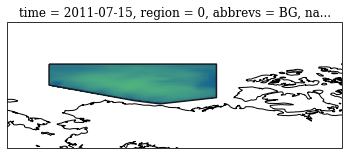

In [72]:
############################################################################
# 3. Extract data from Beaufort Area
############################################################################

# 1) Create a mask:

# Points defining Beaufort extension and polygon attributes
BG = np.array([[-170.0, 80.0], [-130.0, 80.0], [-130.0, 72.0], [-143.5, 70.5], [-149.5, 71.25], [-170.0, 75]])
names = ['Beafort Gyre']
abbrevs = ["BG"]

polygon_bg = regionmask.Regions([BG], names=names, abbrevs=abbrevs, name="BG")

# Create a 3-D masked array (in lat/lon and extension in time of smos_sss)
mask_bg = polygon_bg.mask_3D(fwc_topaz_km3, lat_name='lat', lon_name='lon')
mask_bg = xr.where(mask_bg==1,mask_bg,np.nan)

# 2) Mask the 3D data:
fwc_topaz_m_bg        = fwc_topaz_m.where(mask_bg==1).squeeze()
fwc_topaz_km3_bg      = fwc_topaz_km3.where(mask_bg==1).squeeze()
fwc_smos_topaz_m_bg   = fwc_smos_topaz_m.where(mask_bg==1).squeeze()
fwc_smos_topaz_km3_bg = fwc_smos_topaz_km3.where(mask_bg==1).squeeze()

fwc_smos_topaz5_m_bg   = fwc_smos_topaz5_m.where(mask_bg==1).squeeze()
fwc_smos_topaz5_km3_bg = fwc_smos_topaz5_km3.where(mask_bg==1).squeeze()

fwc_smos_topazv3_m_bg   = fwc_smos_topazv3_m.where(mask_bg==1).squeeze()
fwc_smos_topazv3_km3_bg = fwc_smos_topazv3_km3.where(mask_bg==1).squeeze()

# Check the mask extension -----------------------------------------------------
ax = plt.subplot(111, projection=ccrs.PlateCarree())
h = fwc_topaz_m_bg[6,:,:].plot(
    transform=ccrs.PlateCarree(),
    cmap=cm.haline,
    add_colorbar=False,
    vmax=36)
ax.coastlines()
polygon_bg.plot_regions(ax=ax, add_label=False) # add the outlines of the regions
ax.set_extent([-180, -100, 60, 90], crs=ccrs.PlateCarree())

if show_plots:
    plt.show()
else:
    plt.close()

In [73]:
############################################################################
# 4. Calculate monthly/yearly mean values for BG area
############################################################################

# Monthly means
fwc_topaz_m_bg_mm = fwc_topaz_m_bg.mean(dim=['lat','lon'], skipna=True)
fwc_topaz_km3_bg_mm = fwc_topaz_km3_bg.sum(dim=['lat','lon'], skipna=True)

fwc_smos_topaz_m_bg_mm = fwc_smos_topaz_m_bg.mean(dim=['lat','lon'], skipna=True)
fwc_smos_topaz_km3_bg_mm = fwc_smos_topaz_km3_bg.sum(dim=['lat','lon'], skipna=True)

fwc_smos_topaz5_m_bg_mm = fwc_smos_topaz5_m_bg.mean(dim=['lat','lon'], skipna=True)
fwc_smos_topaz5_km3_bg_mm = fwc_smos_topaz5_km3_bg.sum(dim=['lat','lon'], skipna=True)

fwc_smos_topazv3_m_bg_mm = fwc_smos_topazv3_m_bg.mean(dim=['lat','lon'], skipna=True)
fwc_smos_topazv3_km3_bg_mm = fwc_smos_topazv3_km3_bg.sum(dim=['lat','lon'], skipna=True)

# Yeraly means
fwc_topaz_m_bg_yy = fwc_topaz_m_bg.resample(time='YS').mean(dim='time', skipna=True, keep_attrs=True)
fwc_topaz_m_bg_yy_all = fwc_topaz_m_bg_yy.mean(dim=['lat','lon'], skipna=True)

fwc_topaz_km3_bg_yy = fwc_topaz_km3_bg.resample(time='YS').mean(dim='time', skipna=True, keep_attrs=True)
fwc_topaz_km3_bg_yy_all = fwc_topaz_km3_bg_yy.sum(dim=['lat','lon'], skipna=True)

print(fwc_topaz_m_bg_yy_all.shape)

(9,)


(9,)


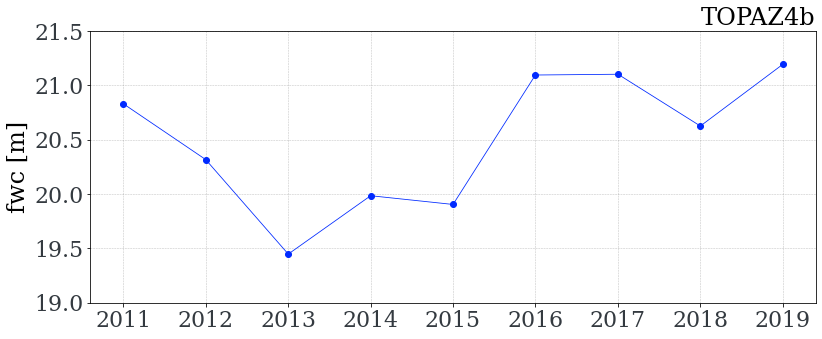

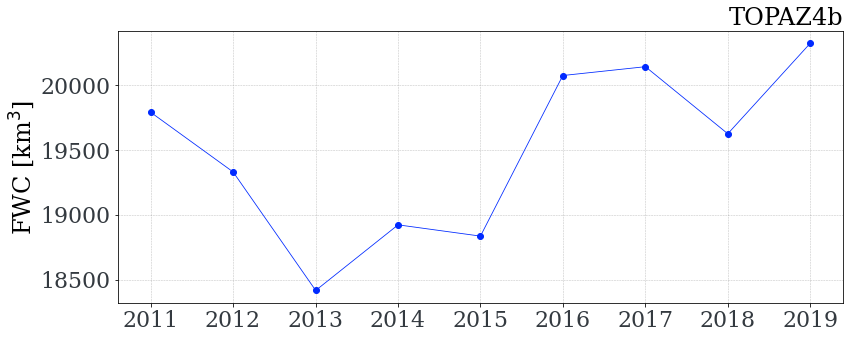

In [75]:
############################################################################
# 5. Yearly lineplot of FWC Topaz (Grafica Eva)
############################################################################

start = datetime.strptime("01-01-2011 12:00:00", "%d-%m-%Y %H:%M:%S")
end   = datetime.strptime("01-01-2019 12:00:00", "%d-%m-%Y %H:%M:%S")
tt_yy = pd.Series(pd.date_range(start, end, freq='YS'))
print(tt_yy.shape)

fig, ax = plt.subplots()

fig = plt.gcf()
fig.set_size_inches(fh, fw)

ax.plot(tt_yy, fwc_topaz_m_bg_yy_all, linestyle ='solid', color = y2_color, alpha=1, linewidth=lw,
        marker='o', markerfacecolor=y2_color, markeredgecolor=y2_color)

ax.set_xlabel('', fontsize=fs)
ax.set_ylabel('fwc [m]', fontsize=fs)
ax.set_yticks(np.arange(19,22,0.5))

#plt.ylim([ylim_left_min, ylim_left_max])
#ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('0.0f'))
ax.tick_params(axis = 'both', which = 'major', labelsize=fs-2, color='black', labelcolor='#343a40')
ax.grid(visible=True, which = 'major', axis = 'both', alpha=0.5, color='gray', linestyle='--', linewidth=0.5)
ax.set_title('TOPAZ4b', loc='right', fontsize=fs)

if show_plots:
    plt.show()
else:
    fig.savefig(path_save_fig+'Timeplot_beaufort_topaz4b_yearly_means_fwc_m.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)

    
    
fig, ax = plt.subplots()

fig = plt.gcf()
fig.set_size_inches(fh, fw)

ax.plot(tt_yy, fwc_topaz_km3_bg_yy_all, linestyle ='solid', color = y2_color, alpha=1, linewidth=lw,
        marker='o', markerfacecolor=y2_color, markeredgecolor=y2_color)

ax.set_xlabel('', fontsize=fs)
ax.set_ylabel('FWC [km$^3$]', fontsize=fs)
#ax.set_yticks(np.arange(19,22,0.5))

#plt.ylim([ylim_left_min, ylim_left_max])
#import matplotlib.ticker as mtick
#ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('0.0f'))
ax.tick_params(axis = 'both', which = 'major', labelsize=fs-2, color='black', labelcolor='#343a40')
ax.grid(visible=True, which = 'major', axis = 'both', alpha=0.5, color='gray', linestyle='--', linewidth=0.5)
ax.set_title('TOPAZ4b', loc='right', fontsize=fs)

if show_plots:
    plt.show()
else:
    fig.savefig(path_save_fig+'Timeplot_beaufort_topaz4b_yearly_means_fwc_km3.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)


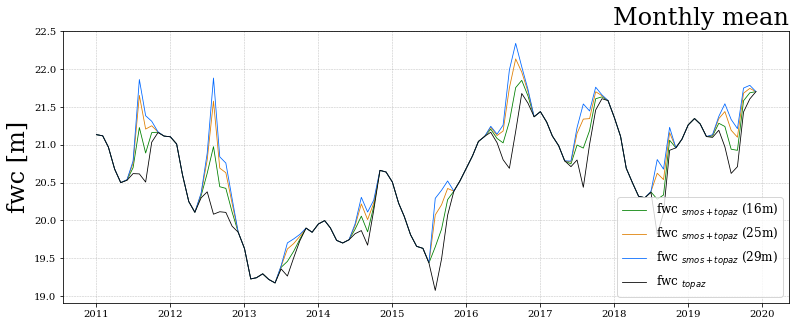

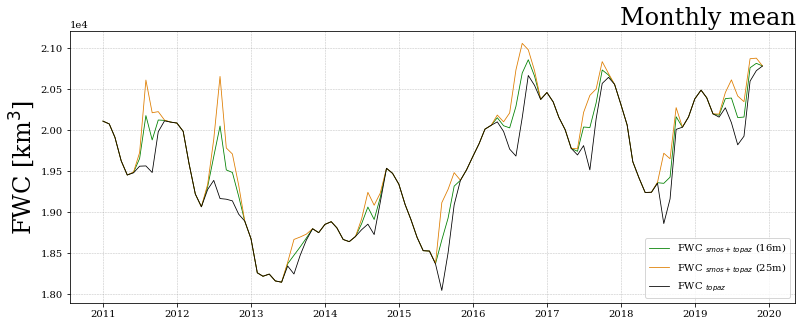

In [86]:
############################################################################
# 6. Monthly lineplot comparing FWC Topaz vs FWC Smos-Topaz
############################################################################

# Create a datetime object
start = datetime.strptime("01-01-2011 12:00:00", "%d-%m-%Y %H:%M:%S")
end   = datetime.strptime("01-12-2019 12:00:00", "%d-%m-%Y %H:%M:%S")
tt = pd.Series(pd.date_range(start, end, freq='MS'))

fig, ax = plt.subplots()

fig = plt.gcf()
fig.set_size_inches(fh, fw)

ax.plot(tt, fwc_smos_topaz_m_bg_mm, linestyle ='solid', color = color2, alpha=1, linewidth=lw, label='fwc $_{smos+topaz}$ ('+v1+')')
ax.plot(tt, fwc_smos_topaz5_m_bg_mm, linestyle ='solid', color = color3, alpha=1, linewidth=lw, label='fwc $_{smos+topaz}$ ('+v2+')')
ax.plot(tt, fwc_smos_topazv3_m_bg_mm, linestyle ='solid', color = color4, alpha=1, linewidth=lw, label='fwc $_{smos+topaz}$ ('+v3+')')
ax.plot(tt, fwc_topaz_m_bg_mm, linestyle ='solid', color = 'black', alpha=1, linewidth=lw, label='fwc $_{topaz}$')
ax.grid(visible=True, which = 'major', axis = 'both', alpha=0.5, color='gray', linestyle='--', linewidth=0.5)

ax.set_xlabel('', fontsize=fs)
ax.set_ylabel('fwc [m]', fontsize=fs)
ax.set_title('Monthly mean', loc='right', fontsize=fs)
ax.legend(loc='lower right',fontsize = 12)

if show_plots:
    plt.show()
else:
    fig.savefig(path_save_fig+'Timeplot_beaufort_monthly_means_comparing_fwc_m_'+v1+'_'+v2+'.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)


fig, ax = plt.subplots()

fig = plt.gcf()
fig.set_size_inches(fh, fw)

ax.plot(tt, fwc_smos_topaz_km3_bg_mm, linestyle ='solid', color = color2, alpha=1, linewidth=lw, label='FWC $_{smos+topaz}$ ('+v1+')')
ax.plot(tt, fwc_smos_topaz5_km3_bg_mm, linestyle ='solid', color = color3, alpha=1, linewidth=lw, label='FWC $_{smos+topaz}$ ('+v2+')')
ax.plot(tt, fwc_topaz_km3_bg_mm, linestyle ='solid', color = 'black', alpha=1, linewidth=lw, label='FWC $_{topaz}$')

ax.ticklabel_format(axis="y", style="sci", scilimits=(4,4))
ax.grid(visible=True, which = 'major', axis = 'both', alpha=0.5, color='gray', linestyle='--', linewidth=0.5)

ax.set_xlabel('', fontsize=fs)
ax.set_ylabel('FWC [km$^3$]', fontsize=fs)
ax.set_title('Monthly mean', loc='right', fontsize=fs)
ax.legend(loc='lower right')

if show_plots:
    plt.show()
else:
    fig.savefig(path_save_fig+'Timeplot_beaufort_monthly_means_comparing_fwc_km3_'+v1+'_'+v2+'.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)

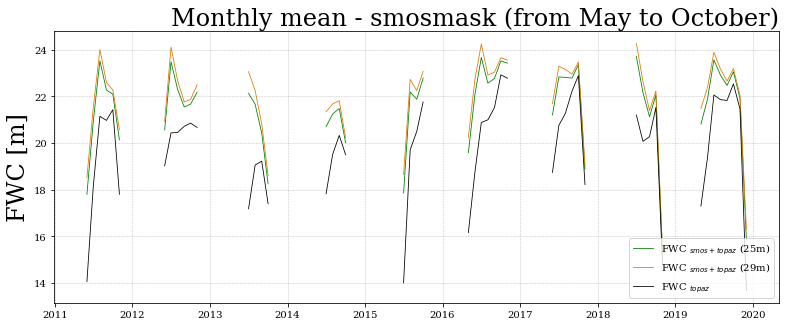

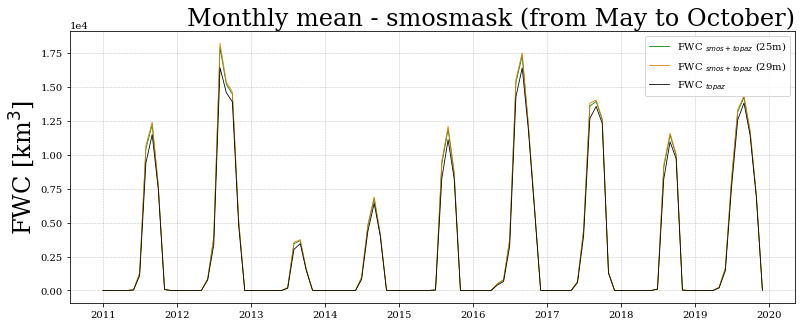

In [45]:
############################################################################
# 7. Monthly lineplot comparing FWC Topaz vs FWC Smos-Topaz (SMOS_mask)
############################################################################

# Create a mask with smos extension ----------------------------------------

# Every value >=0 is transformed in 5, the rest will be NA
mask_smos = xr.where(sss_smos>=0, 5, np.nan)

# Apply the mask
fwc_topaz_m_bg_smosmask        = fwc_topaz_m_bg.where(mask_smos==5)
fwc_topaz_km3_bg_smosmask      = fwc_topaz_km3_bg.where(mask_smos==5)

fwc_smos_topaz_m_bg_smosmask   = fwc_smos_topaz_m_bg.where(mask_smos==5)
fwc_smos_topaz_km3_bg_smosmask = fwc_smos_topaz_km3_bg.where(mask_smos==5)

fwc_smos_topaz5_m_bg_smosmask   = fwc_smos_topaz5_m_bg.where(mask_smos==5)
fwc_smos_topaz5_km3_bg_smosmask = fwc_smos_topaz5_km3_bg.where(mask_smos==5)

# Calculate means over the area
fwc_topaz_m_bg_smosmask_mm   = fwc_topaz_m_bg_smosmask.mean(dim=['lat','lon'], skipna=True)
fwc_topaz_km3_bg_smosmask_mm = fwc_topaz_km3_bg_smosmask.sum(dim=['lat','lon'], skipna=True)

fwc_smos_topaz_m_bg_smosmask_mm = fwc_smos_topaz_m_bg_smosmask.mean(dim=['lat','lon'], skipna=True)
fwc_smos_topaz_km3_bg_smosmask_mm = fwc_smos_topaz_km3_bg_smosmask.sum(dim=['lat','lon'], skipna=True)

fwc_smos_topaz5_m_bg_smosmask_mm = fwc_smos_topaz5_m_bg_smosmask.mean(dim=['lat','lon'], skipna=True)
fwc_smos_topaz5_km3_bg_smosmask_mm = fwc_smos_topaz5_km3_bg_smosmask.sum(dim=['lat','lon'], skipna=True)

# Plots -------------------------------------------------------------------

fig, ax = plt.subplots()

fig = plt.gcf()
fig.set_size_inches(fh, fw)

ax.plot(tt, fwc_smos_topaz_m_bg_smosmask_mm, linestyle ='solid', color = color2, alpha=1, linewidth=lw, label='FWC $_{smos+topaz}$ ('+v1+')')
ax.plot(tt, fwc_smos_topaz5_m_bg_smosmask_mm, linestyle ='solid', color = color3, alpha=1, linewidth=lw, label='FWC $_{smos+topaz}$ ('+v2+')')
ax.plot(tt, fwc_topaz_m_bg_smosmask_mm, linestyle ='solid', color = 'black', alpha=1, linewidth=lw, label='FWC $_{topaz}$')

ax.grid(visible=True, which = 'major', axis = 'both', alpha=0.5, color='gray', linestyle='--', linewidth=0.5)

ax.set_xlabel('', fontsize=fs)
ax.set_ylabel('FWC [m]', fontsize=fs)
ax.set_title('Monthly mean - smosmask (from May to October)', loc='right', fontsize=fs)
ax.legend(loc='lower right')
#plt.ylim([12,24])

if show_plots:
    plt.show()
else:
    fig.savefig(path_save_fig+'Timeplot_beaufort_smosmask_monthly_means_comparing_fwc_m_'+v1+'_'+v2+'.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)

#---------------------------------------------------------------------------

fig, ax = plt.subplots()

fig = plt.gcf()
fig.set_size_inches(fh, fw)

ax.plot(tt, fwc_smos_topaz_km3_bg_smosmask_mm, linestyle ='solid', color = color2, alpha=1, linewidth=lw, label='FWC $_{smos+topaz}$ ('+v1+')')
ax.plot(tt, fwc_smos_topaz5_km3_bg_smosmask_mm, linestyle ='solid', color = color3, alpha=1, linewidth=lw, label='FWC $_{smos+topaz}$ ('+v2+')')
ax.plot(tt, fwc_topaz_km3_bg_smosmask_mm, linestyle ='solid', color = 'black', alpha=1, linewidth=lw, label='FWC $_{topaz}$')

ax.ticklabel_format(axis="y", style="sci", scilimits=(4,4))
ax.grid(visible=True, which = 'major', axis = 'both', alpha=0.5, color='gray', linestyle='--', linewidth=0.5)

ax.set_xlabel('', fontsize=fs)
ax.set_ylabel('FWC [km$^3$]', fontsize=fs)
ax.set_title('Monthly mean - smosmask (from May to October)', loc='right', fontsize=fs)
ax.legend(loc='upper right')
#plt.ylim([10000,16000])

if show_plots:
    plt.show()
else:
    fig.savefig(path_save_fig+'Timeplot_beaufort_smosmask_monthly_means_comparing_fwc_km3_'+v1+'_'+v2+'.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)

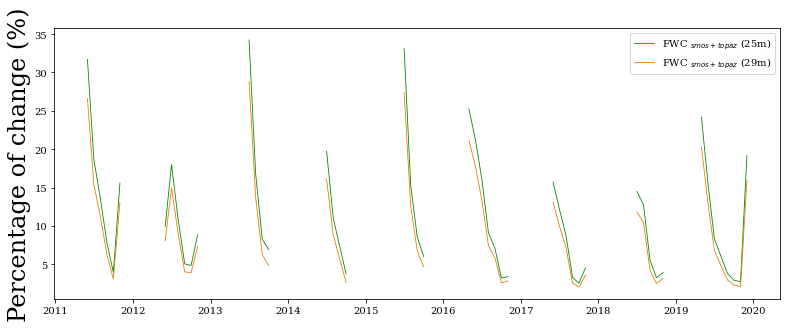

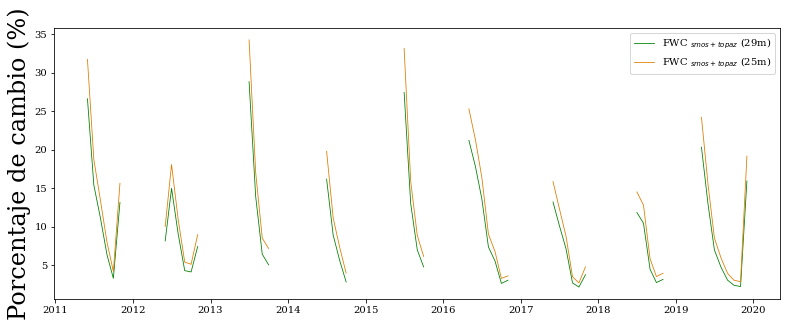

Porcentaje de cambio promedio: 25m <xarray.DataArray ()>
array(9.50087644)
Coordinates:
    region   int64 0
    abbrevs  <U2 'BG'
    names    <U12 'Beafort Gyre'
Porcentaje de cambio promedio: 29m <xarray.DataArray ()>
array(11.60714081)
Coordinates:
    region   int64 0
    abbrevs  <U2 'BG'
    names    <U12 'Beafort Gyre'


In [46]:
############################################################################
# 8. Percentage of change between topaz and smos-topaz
############################################################################

perc_change1 = ((fwc_smos_topaz5_m_bg_smosmask_mm - fwc_topaz_m_bg_smosmask_mm) / fwc_topaz_m_bg_smosmask_mm)*100
perc_change2 = ((fwc_smos_topaz_m_bg_smosmask_mm - fwc_topaz_m_bg_smosmask_mm) / fwc_topaz_m_bg_smosmask_mm)*100

fig, ax = plt.subplots()

fig = plt.gcf()
fig.set_size_inches(fh, fw)

ax.plot(tt, perc_change1, linestyle ='solid', color = color2, alpha=1, linewidth=lw, label='FWC $_{smos+topaz}$ ('+v1+')')
ax.plot(tt, perc_change2, linestyle ='solid', color = color3, alpha=1, linewidth=lw, label='FWC $_{smos+topaz}$ ('+v2+')')
ax.set_ylabel('Percentage of change (%)', fontsize=fs)
#ax.set_title('((FWCsmos+topaz(5m)'+'- FWCtopaz)' +'/FWCtopaz)', loc='right', fontsize=fs)
ax.legend()

if show_plots:
    plt.show()
else:
    fig.savefig(path_save_fig+'Timeplot_beaufort_smosmask_monthly_means_percentaje_m_'+v1+'_'+v2+'.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)

perc_change1 = ((fwc_smos_topaz_km3_bg_smosmask_mm - fwc_topaz_km3_bg_smosmask_mm) / fwc_topaz_km3_bg_smosmask_mm)*100
perc_change2 = ((fwc_smos_topaz5_km3_bg_smosmask_mm - fwc_topaz_km3_bg_smosmask_mm) / fwc_topaz_km3_bg_smosmask_mm)*100

fig, ax = plt.subplots()

fig = plt.gcf()
fig.set_size_inches(fh, fw)

ax.plot(tt, perc_change1, linestyle ='solid', color = color2, alpha=1, linewidth=lw, label='FWC $_{smos+topaz}$ ('+v2+')')
ax.plot(tt, perc_change2, linestyle ='solid', color = color3, alpha=1, linewidth=lw, label='FWC $_{smos+topaz}$ ('+v1+')')
ax.set_ylabel('Porcentaje de cambio (%)', fontsize=fs)
#ax.set_title('((FWCsmos+topaz(5m)'+'- FWCtopaz)' +'/FWCtopaz)', loc='right', fontsize=fs)
ax.legend()

if show_plots:
    plt.show()
else:
    fig.savefig(path_save_fig+'Timeplot_beaufort_smosmask_monthly_means_percentaje_km3_'+v1+'_'+v2+'.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)

print('Porcentaje de cambio promedio:',v1, perc_change1.mean())
print('Porcentaje de cambio promedio:',v2, perc_change2.mean())
